<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Supervised Machine Learning: Classification - Final Assignment</font></h1>


## Import the required libraries


In [1]:
#suppres warnings

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, f1_score

In [4]:
#Define function that calculates metrics

def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [58]:
#!mamba install -y xgboost

## Importing the Dataset


To perform classification, we'll work with a loan dataset that contains information about various individuals. This dataset includes their demographic details, financial information, and loan status. Our goal is to use this data to classify or predict the loan status for future applicants.

In [5]:
data = pd.read_csv('loan_data_set.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# 1. About the Data


In upcoming section we'll perform basic exploratory data analysis.

In [6]:
# Number of rows and columns
print(data.shape)

# Column names
print(data.columns.tolist())

# Data types
print(data.dtypes)

(614, 13)
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [7]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
#checking for duplicates

duplicate = data[data.duplicated(['Loan_ID'])]
duplicate   #no duplicates

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


We can observe that our dataset contains a blend of categorical and numerical variables, with a total of 614 observations and no duplicate values.

In [9]:
#remove Loan_ID column

data = data.drop(data.columns[0], axis=1)

Loan_Id column is redundant because it doesn't convey meaningful information and isn't applicable in classification models.

In [10]:
unique_values_all_columns = {}
for column in data.select_dtypes(include=['object']):
    unique_values_all_columns[column] = data[column].unique()

for column, unique_values in unique_values_all_columns.items():
    print(f"Unique values in '{column}':")
    print(unique_values)
    print()

Unique values in 'Gender':
['Male' 'Female' nan]

Unique values in 'Married':
['No' 'Yes' nan]

Unique values in 'Dependents':
['0' '1' '2' '3+' nan]

Unique values in 'Education':
['Graduate' 'Not Graduate']

Unique values in 'Self_Employed':
['No' 'Yes' nan]

Unique values in 'Property_Area':
['Urban' 'Rural' 'Semiurban']

Unique values in 'Loan_Status':
['Y' 'N']



In [11]:
for column in data.select_dtypes(include=['object']):
    print(f"Value counts for '{column}':")
    print(data[column].value_counts())
    print()

Value counts for 'Gender':
Male      489
Female    112
Name: Gender, dtype: int64

Value counts for 'Married':
Yes    398
No     213
Name: Married, dtype: int64

Value counts for 'Dependents':
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

Value counts for 'Education':
Graduate        480
Not Graduate    134
Name: Education, dtype: int64

Value counts for 'Self_Employed':
No     500
Yes     82
Name: Self_Employed, dtype: int64

Value counts for 'Property_Area':
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

Value counts for 'Loan_Status':
Y    422
N    192
Name: Loan_Status, dtype: int64



Since almost all categorical columns are unevenly distributed and unbalanced, we have to perform stratified splitting. 

In [12]:
data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
#fill null values for categorical variables

for column in data.select_dtypes(include=['object']):
    data[column].fillna(data[column].mode()[0],inplace=True)

In [14]:
#fill null values for numerical variables

for column in data.select_dtypes(include=['int64','float64']):
    data[column].fillna(data[column].mean(),inplace=True)

To handle the small number of missing values in our dataset, we have opted to fill the categorical variables with the mode (most common value) and the numerical variables with the mean value. This approach allows us to impute the missing values effectively while preserving the overall integrity of the data.

IndexError: index 2 is out of bounds for axis 0 with size 2

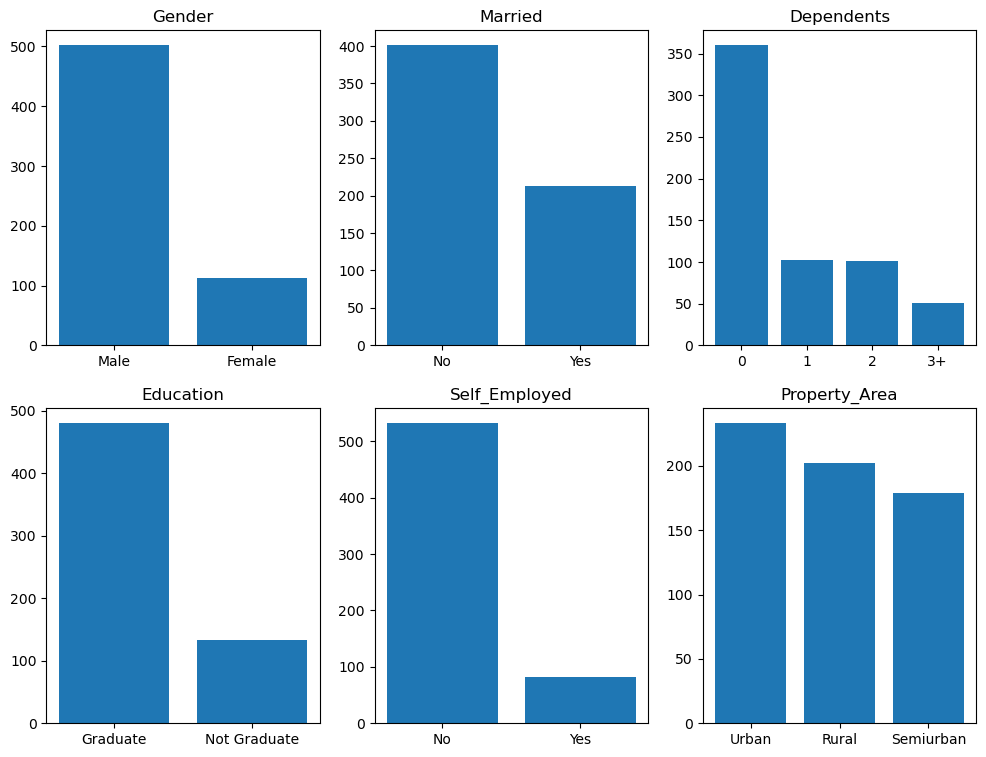

In [15]:
#distribution of categorical variables

categorical_columns = data.select_dtypes(include=['object']).columns

# Set up the grid layout
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# Iterate over the categorical columns and plot histograms
for i, column in enumerate(categorical_columns):
    row = i // num_cols
    col = i % num_cols
    
    # Get unique values and their counts
    unique_values = data[column].unique()
    value_counts = data[column].value_counts()
    
    # Create a bar plot
    axes[row, col].bar(unique_values, value_counts)
    axes[row, col].set_title(column)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

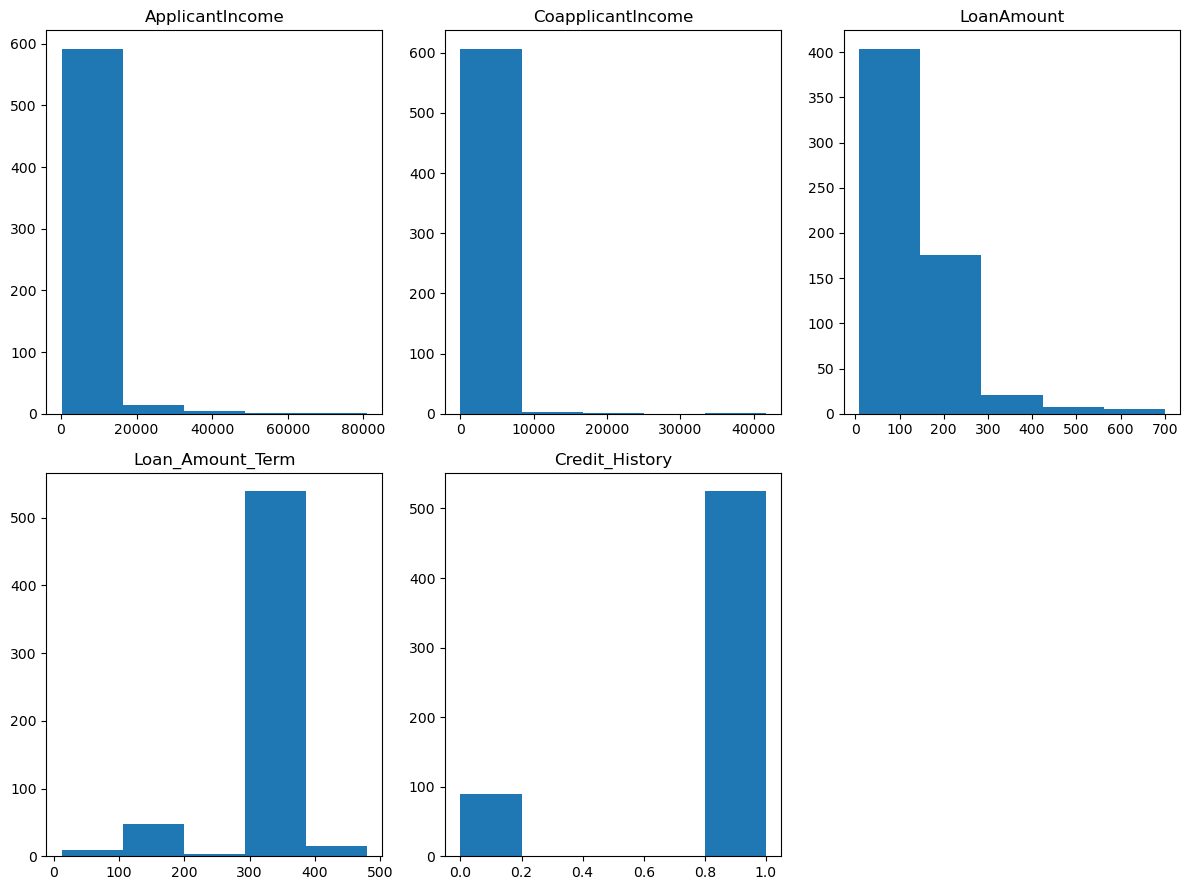

In [16]:
#distribution of numerical variables

numerical_columns = data.select_dtypes(include=['int64','float64']).columns

# Set up the grid layout
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# Iterate over the categorical columns and plot histograms
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    
    # Create a bar plot
    axes[row, col].hist(data[column], bins=5)
    axes[row, col].set_title(column)

# Remove empty subplots if the number of categorical columns is less than 3x4
if len(numerical_columns) < num_rows * num_cols:
    for i in range(len(numerical_columns), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()  

When we look at the histograms, we can see that the categorical variables are not evenly distributed, meaning some categories have more samples than others. On the other hand, the numerical variables show a skewness, which means they are not evenly spread out and might have a long tail on one side. 

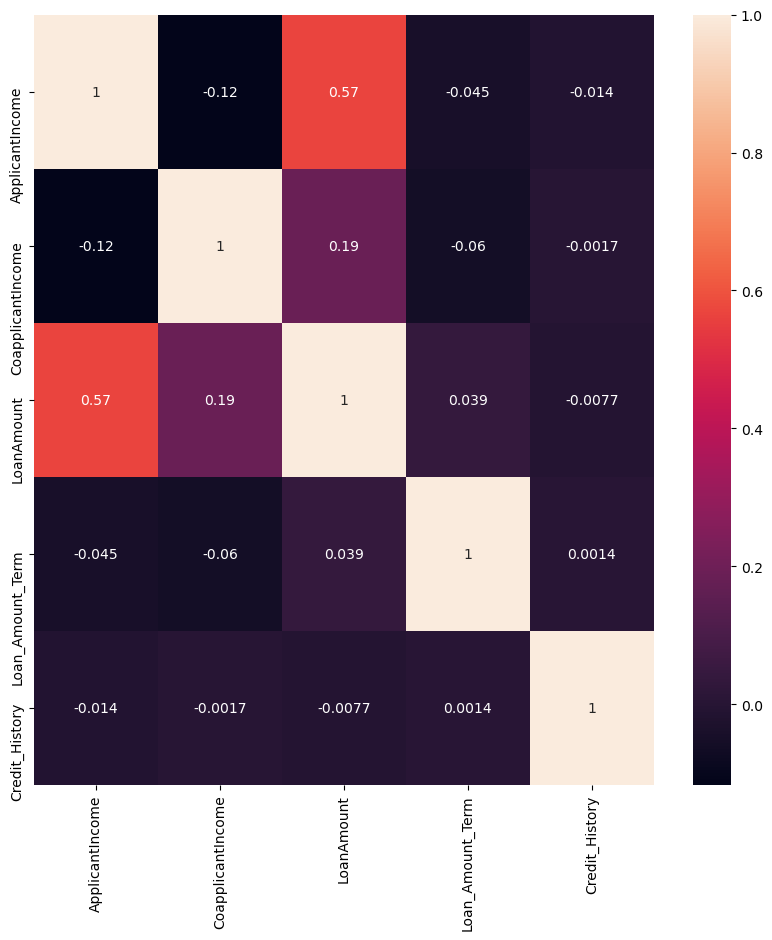

In [17]:
#correlation between variables

plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)

plt.show()

Before feeding our data into classification algorithms, it is important to perform scaling and standardization. Scaling ensures that all features are on a similar scale, while standardization transforms the data to have zero mean and unit variance. 

In [18]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scaling the raw input features
X = scaler.fit_transform(data[numerical_columns])
data[numerical_columns] = X

In [19]:
#one-hot encoding

one_hot_encode_cols = data.dtypes[data.dtypes == np.object] 
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  

data = pd.get_dummies(data, columns=one_hot_encode_cols, drop_first=True)

In [20]:
#correlation with target variable

correlation = data.corr()['Loan_Status_Y'].sort_values()
correlation

Education_Not Graduate    -0.085884
CoapplicantIncome         -0.059187
Property_Area_Urban       -0.043621
Dependents_1              -0.038740
LoanAmount                -0.036416
Dependents_3+             -0.026123
Loan_Amount_Term          -0.020974
ApplicantIncome           -0.004710
Self_Employed_Yes         -0.003700
Gender_Male                0.017987
Dependents_2               0.062384
Married_Yes                0.091478
Property_Area_Semiurban    0.136540
Credit_History             0.540483
Loan_Status_Y              1.000000
Name: Loan_Status_Y, dtype: float64

Among all variables, it appears that "Credit History" is the only variable that shows a strong correlation with "Loan Status." The remaining variables show lower correlations. However, we will include all variables in our classification models to capture the collective influence they may have on predicting loan status. While their individual correlations may be weaker, the combined effect of multiple variables can still contribute valuable information to our models.

In [21]:
#Identifying outliers

z = np.abs(stats.zscore(data[numerical_columns]))
print(np.where(z > 3))

(array([  9,  14,  68,  94, 126, 130, 133, 155, 155, 171, 171, 177, 177,
       183, 185, 242, 262, 278, 308, 313, 333, 333, 369, 402, 409, 417,
       432, 443, 487, 495, 497, 506, 523, 525, 546, 561, 575, 581, 585,
       600, 604]), array([1, 3, 3, 3, 0, 2, 3, 0, 2, 0, 2, 1, 2, 0, 0, 3, 3, 2, 2, 3, 0, 2,
       2, 1, 0, 1, 2, 0, 2, 3, 3, 2, 2, 2, 3, 2, 3, 1, 3, 1, 2]))


There are a few outliers in the data, but their number is relatively small compared to the entire dataset. Therefore, we have made the decision to retain these outliers in our analysis rather than remove them. By keeping them, we aim to maintain the integrity of the data and avoid potential information loss that could occur if we were to remove them.

In [22]:
#Stratified spliting 

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data, data['Loan_Status_Y']))

# Create the dataframes
X_train = data.loc[train_idx, :]
y_train = data.loc[train_idx, 'Loan_Status_Y']

X_test  = data.loc[test_idx, :]
y_test  = data.loc[test_idx, 'Loan_Status_Y']

Since the categorical columns in our dataset are unevenly distributed and unbalanced, we should use stratified splitting. This helps us make sure that the training and testing datasets have a fair representation of each category. By doing this, we can avoid biases and train our models on a more accurate and balanced dataset.

# 2. Objectives


Our objective is to build predictive classification models using a sequential approach, starting with logistic regression, followed by k-nearest neighbors (KNN), and concluding with gradient boosting. The aim of this analysis is to leverage the loan dataset we previously explored to develop accurate models that can predict loan status effectively. 

Through logistic regression, we will utilize the features within the dataset to create a model that can classify whether a loan application is approved or not. We will assess the model's performance and evaluate its ability to make accurate predictions based on the provided data.

Moving on to KNN, we will explore the power of this algorithm in classifying loan applications based on their proximity to other instances. By fine-tuning the value of k, we can find an optimal balance between bias and variance, leading to the best possible predictions.

Finally, we will delve into gradient boosting, a powerful ensemble method that combines weak learners to create a robust and accurate classification model. This technique aims to iteratively minimize errors and optimize predictions by leveraging the collective knowledge of multiple models.

# 3. Classification Models


### Logistic Regression

In [23]:
logistic_model = LogisticRegression()

In [24]:
param_grid = {
    'penalty': ['l1', 'l2'],  
    'C': [0.1, 1.0, 10.0]  
}

In [25]:
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5)

In [26]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']})

In [27]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('parameters: ',best_params)
print('score: ',best_score)

parameters:  {'C': 0.1, 'penalty': 'l2'}
score:  1.0


In [28]:
logistic_model = LogisticRegression(**best_params)
logistic_model.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [29]:
prediction = logistic_model.predict(X_test)

In [30]:
evaluate_metrics(y_test, prediction)

{'accuracy': 1.0,
 'recall': array([1., 1.]),
 'precision': array([1., 1.]),
 'f1score': array([1., 1.])}

In [31]:
cf = confusion_matrix(y_test, prediction)

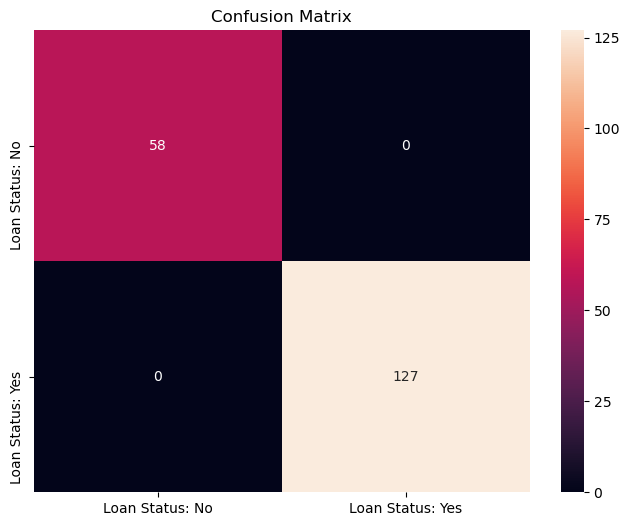

In [32]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf, annot=True, fmt="d", xticklabels=["Loan Status: No", "Loan Status: Yes"],
                 yticklabels=["Loan Status: No", "Loan Status: Yes"])
ax.set(title="Confusion Matrix");

Based on the grid search results, the best parameters for the logistic regression model are C=0.1 and penalty=l1. However, upon evaluating the model's performance metrics, such as accuracy, recall, precision, and F1 score, we notice that all of them are equal to 1. This indicates that the model is likely overfitting the training data and may not generalize well to new, unseen data.

### K-Nearest Neighbour (KNN)

In [33]:
knn_model = KNeighborsClassifier()

In [34]:
param_grid = {
    'n_neighbors': np.arange(1,41,1),  
    'weights': ['uniform', 'distance'],  
    'p': [1, 2]  
}

In [35]:
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5)

In [36]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [37]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('parameters: ',best_params)
print('score: ',best_score)

parameters:  {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
score:  0.9929958960328318


Text(0.5, 1.0, 'KNN F1 Score')

<Figure size 1920x1440 with 0 Axes>

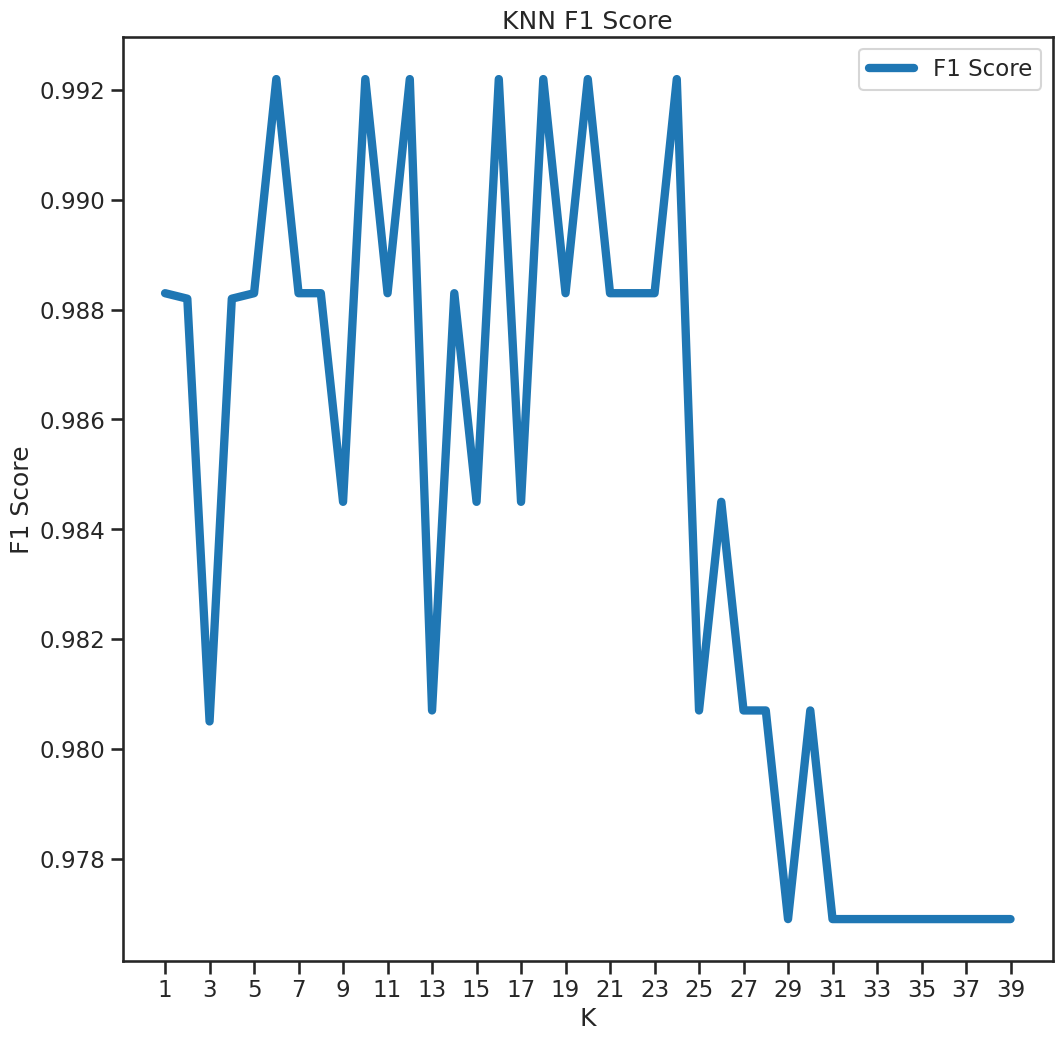

In [38]:
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')

In [39]:
knn_model = KNeighborsClassifier(n_neighbors=24, p=2, weights='uniform')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=24)

In [40]:
prediction = knn_model.predict(X_test)

In [41]:
evaluate_metrics(y_test, prediction)

{'accuracy': 0.9891891891891892,
 'recall': array([0.96551724, 1.        ]),
 'precision': array([1.        , 0.98449612]),
 'f1score': array([0.98245614, 0.9921875 ])}

In [42]:
cf = confusion_matrix(y_test, prediction)

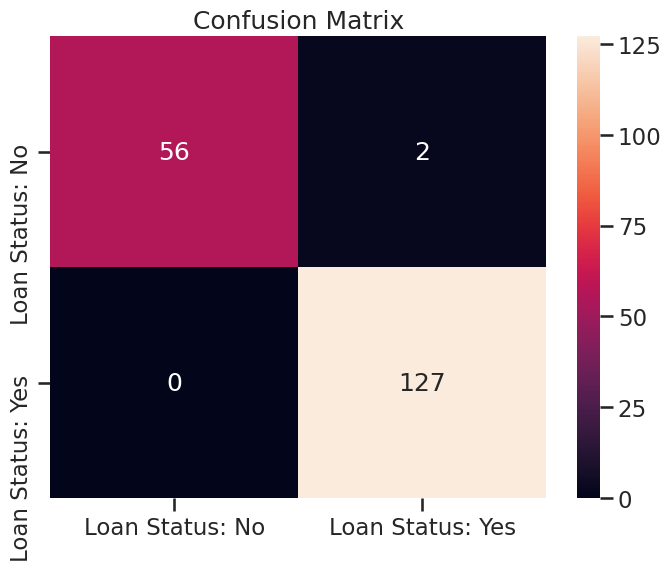

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf, annot=True, fmt="d", xticklabels=["Loan Status: No", "Loan Status: Yes"],
                 yticklabels=["Loan Status: No", "Loan Status: Yes"])
ax.set(title="Confusion Matrix");

After conducting a grid search for the KNN (k-nearest neighbors) model, we determined that the optimal number of neighbors (k) is 1. However, upon closer examination of a graph depicting the relationship between the F1 score and the value of k, we observed some oscillations. Interestingly, after k=24, the F1 score starts to decline sharply.

Considering these insights, we made an informed decision to set the number of neighbors to 24 in our KNN model. Additionally, we chose to utilize the Euclidean distance metric and uniform weights. Our KNN model exhibits remarkable performance metrics, including high accuracy, precision, recall, and F1 score. This indicates that the model is highly effective in making predictions, and it holds significant promise as a reliable predictive tool for loan classification.

### Gradient Boosting

In [44]:
XGB_model = XGBClassifier(objective='binary:logistic',eval_metric='mlogloss')

In [45]:
param_grid = {'learning_rate': [0.1*(n+1) for n in range(5)],
             'n_estimators' : [2*n+1 for n in range(5)]}

In [46]:
grid_search = GridSearchCV(estimator=XGB_model, param_grid=param_grid,scoring="neg_log_loss")

In [47]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                            

In [48]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('parameters: ',best_params)
print('score: ',best_score)

parameters:  {'learning_rate': 0.5, 'n_estimators': 9}
score:  -0.008216439596111038


In [49]:
XGB_model = XGBClassifier(objective='binary:logistic',eval_metric='mlogloss',**best_params)
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=9, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
prediction = XGB_model.predict(X_test)

In [51]:
evaluate_metrics(y_test, prediction)

{'accuracy': 1.0,
 'recall': array([1., 1.]),
 'precision': array([1., 1.]),
 'f1score': array([1., 1.])}

In [52]:
cf = confusion_matrix(y_test, prediction)

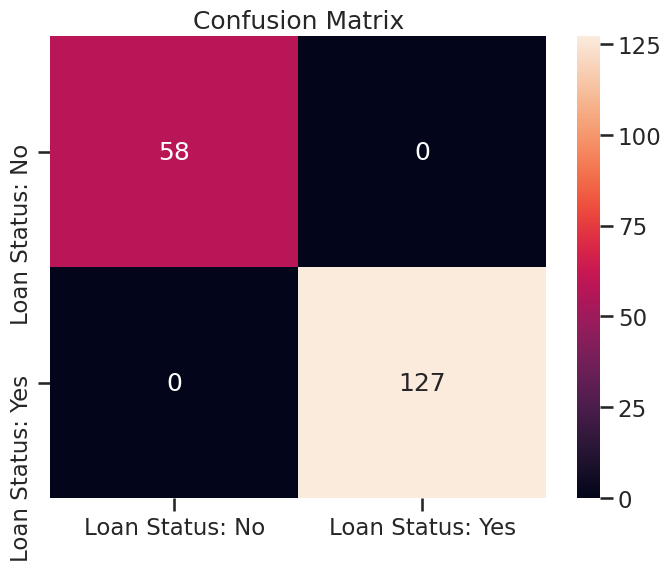

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf, annot=True, fmt="d", xticklabels=["Loan Status: No", "Loan Status: Yes"],
                 yticklabels=["Loan Status: No", "Loan Status: Yes"])
ax.set(title="Confusion Matrix");

Following the grid search for the gradient boosting model, we identified that the optimal parameters are a learning rate of 0.5 and 9 estimators. However, upon evaluating the model's performance metrics, we observed signs of overfitting.

# 4. Insights and key findings


During our analysis and development of predictive models using the loan dataset, we gained several insightful findings:

* Categorical Variables: We observed that the categorical variables in the dataset are unevenly distributed, indicating imbalances among different categories. This suggests the need for careful consideration when interpreting and utilizing these variables in our models.

* Numerical Variables: The numerical variables displayed high skewness, indicating a non-normal distribution. This characteristic highlights the importance of appropriate preprocessing techniques such as scaling or transformation to ensure accurate modeling.

* Feature Selection: Despite lower correlations with loan status for most variables, we decided to include all variables in our classification models. While their individual correlations may be weaker, the combined effect of multiple variables can still contribute valuable information for predicting loan status.

* Stratified Splitting: Due to the uneven distribution and imbalance in the categorical variables, we employed stratified splitting during the train-test split process. This approach helps maintain a representative distribution of categories in both training and testing datasets, leading to more accurate model evaluation.

* Model Evaluation: When analyzing the performance of different models, we encountered various scenarios. The logistic regression model, despite achieving optimal parameter values, showed signs of overfitting, as evidenced by perfect scores across evaluation metrics. This implies the need for regularization and further model tuning.

* KNN Model: The KNN model revealed that the optimal number of neighbors (k) was determined to be 1 through grid search. However, careful examination of the F1 score graph uncovered a decline beyond k=24, leading us to choose this value for improved model stability.

* Gradient Boosting: The grid search for gradient boosting highlighted a learning rate of 0.5 and 9 estimators as the best parameters. However, overfitting became evident during model evaluation, indicating the need for adjustments to prevent excessive complexity and improve generalization.

# 5. Next Steps


Suggested further steps may involve:

* Model Tuning: Continuously fine-tune the hyperparameters of the models to optimize their performance. 
* Ensemble Methods: We can consider employing ensemble methods, such as random forests or stacking, to combine the predictions of multiple models. 
* Model Deployment: Once satisfied with the performance of the models, we should consider deploying them in a real-world scenario. 

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
